In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from matplotlib.patches import Ellipse
from scipy import linalg
from sklearn.decomposition import PCA

import utils

In [2]:
sustain_w_regions = pd.read_csv("../data/sustainability_w_regions.csv")
sustain_w_regions = sustain_w_regions.drop(
    columns=[
        "country-code",
        "World Regions (UN SDG Definition)",
        "Continent",
        "region",
        "region-code",
        "iso_3166-2",
        "name",
        "alpha-2",
        "sub-region",
        "intermediate-region",
        "sub-region-code",
        "intermediate-region-code",
        "Income Classification (World Bank Definition)"
    ]
)
# Rename features with shorter names so the labels aren't
# too long for the visualizations
rename = dict(zip(list(sustain_w_regions.columns), utils.feature_short_names))

df = sustain_w_regions.rename(rename, axis=1)

# Save name mapping
pickle.dump(rename, open("rename_mapping.pickle", "wb"))

### Data Cleaning - Deal with Null Values
- Automatically drop any column with more than 50% nulls.
- Interpolate values using backwards fill for nulls, ensure df is sorted by country and year first. Forward fill in any remaining cases that backwards fill can't (e.g. 2018 - the last year in the dataset)
- Also drop Income Classification variable automatically because we will have to encode it, but other variables like GDP per Capita cover this measure, so we can just drop it.

Note: Nulls are read in/recorded as 0s in many cases

In [3]:
for column in df.columns:
    pct_null = len(df[(df[column] == 0) | df[column].isnull()]) / len(df)
    if pct_null > 0.5:
        print(f"{column} has {pct_null} proportion null")

Net Forest Depletion (% GNI) has 0.6811682385153636 proportion null
Below Internatl. Poverty Line (%) has 0.6568299361119562 proportion null
Population Covered by 3G+ Network (%) has 0.6105871615454822 proportion null
Gini Index has 0.6035898996045026 proportion null


In [4]:
df = df.drop(
    columns=[
        "Net Forest Depletion (% GNI)",
        "Below Internatl. Poverty Line (%)",
        "Population Covered by 3G+ Network (%)",
        "Gini Index",
    ]
)

Interpolate

In [5]:
df = df.sort_values(by=["Name", "Year"]).groupby("Name").bfill().ffill()

We need to convert "Regime Type" into integers representing each discrete option- e.g. an encoding.

In [6]:
encoding = pd.Series(pd.factorize(df["Regime Type"])[0], index=df.index)
encoding.name = "encoding"

df = df.merge(encoding, left_index=True, right_index=True, how="inner").drop(
    columns='Regime Type'
).rename(
    columns={'encoding': 'Regime Type'}
)

For PCA, only taking one entry for each country (the last year in the data, for instance) appears to be the best approach.

This also makes sense since we plan on clustering the countries, not doing a time-series model at first.

In [7]:
df = df.drop_duplicates(subset=['Alpha-2'], keep='last')

Drop metadata columns - no longer needed; **however WE MUST ensure that when we merge them back, we sort by name and year first so the indices align.**

In [8]:
# Name is already gone due to the groupby
df = df.drop(columns=["Alpha-2", "Year"])

### PCA Without Dropping Highly Correlated Features

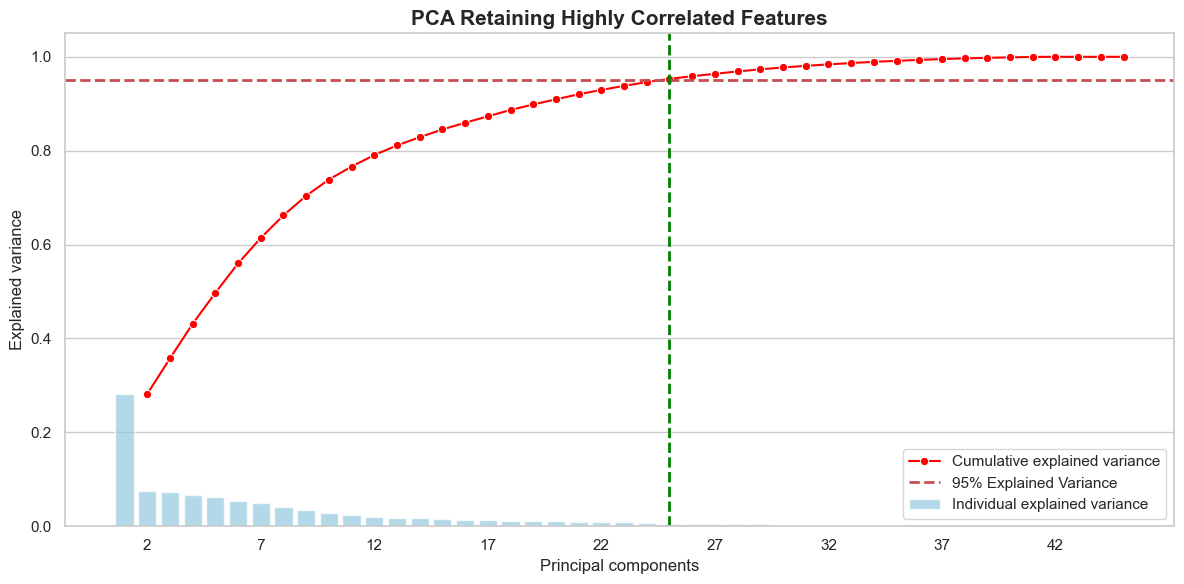

In [9]:
pca, pca_df = utils.create_pca(df)
init_pca_viz = utils.viz_pca(pca, "Retaining Highly Correlated Features")
init_pca_viz.show()

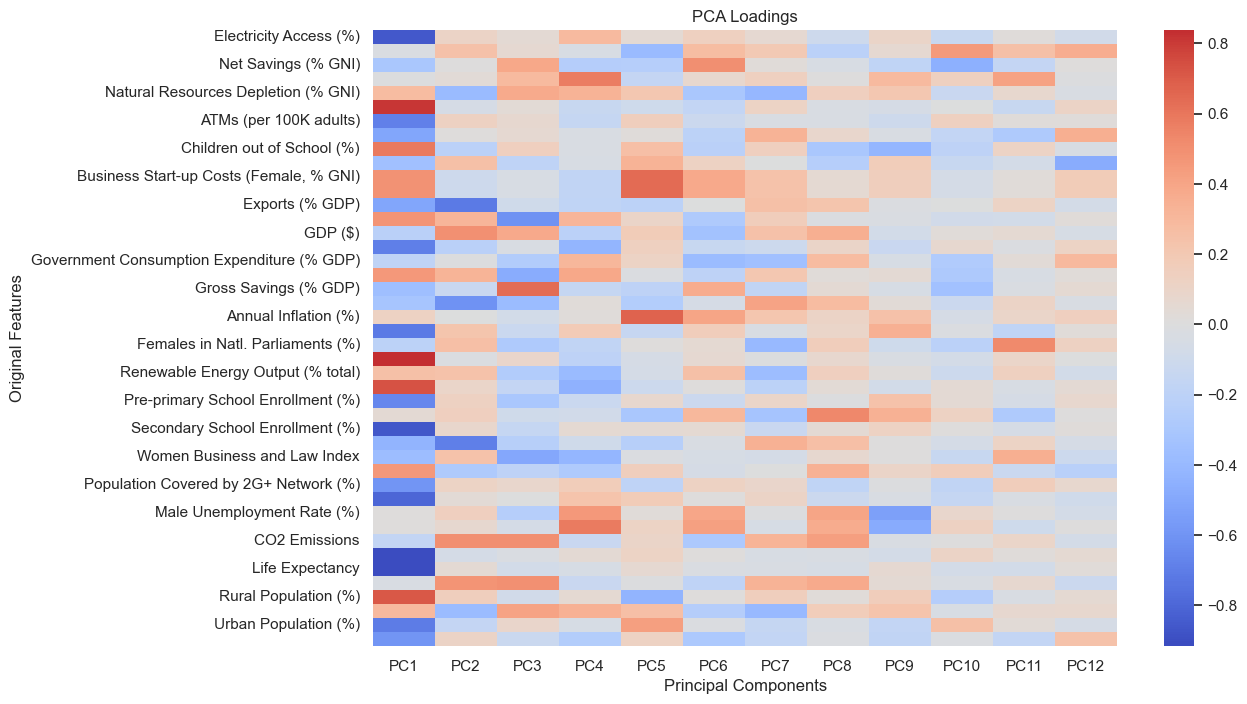

In [10]:
num_components = 12
init_pca_n, init_pca_heatmap = utils.viz_pca_heatmap(df, 12)
init_pca_heatmap.show()

In [11]:
init_loadings = utils.create_loadings(df, init_pca_n)
utils.print_top_features_for_component(init_pca_n, init_loadings, 5)

PC1 top 5 features and explained variance:
Population Using Internet (%): 0.8389
Life Expectancy: 0.8347
Secondary School Enrollment (%): 0.7475
Electricity Access (%): 0.7374
Pupil-teacher Ratio: 0.7019

PC2 top 5 features and explained variance:
Exports (% GDP): 0.5082
Trade (% GDP): 0.4783
Imports (% GDP): 0.3755
CO2 Emissions: 0.2562
GDP ($): 0.2428

PC3 top 5 features and explained variance:
Gross Savings (% GDP): 0.4067
Consumption Expenditure (% GDP): 0.3744
CO2 Emissions: 0.2535
Women Business and Law Index: 0.2532
Total Population: 0.2428

PC4 top 5 features and explained variance:
Female Unemployment Rate (%): 0.3353
Carbon Dioxide Damage (% GNI): 0.3323
Male Unemployment Rate (%): 0.2095
Renewable Energy Consumption (% total): 0.2026
GDP per Capita ($): 0.1790

PC5 top 5 features and explained variance:
Annual Inflation (%): 0.4535
Business Start-up Costs (Male, % GNI): 0.4141
Business Start-up Costs (Female, % GNI): 0.4140
Urban Population (%): 0.1866
Rural Population (%): 

### Feature Selection and Engineering (Dealing with Highly Correlated Features)

In [12]:
init_corr = df.corr()

/var/folders/j0/5yfrsf617z7b5_lkbnsqzmh80000gn/T/ipykernel_65491/2318300724.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  init_corr_viz.show()


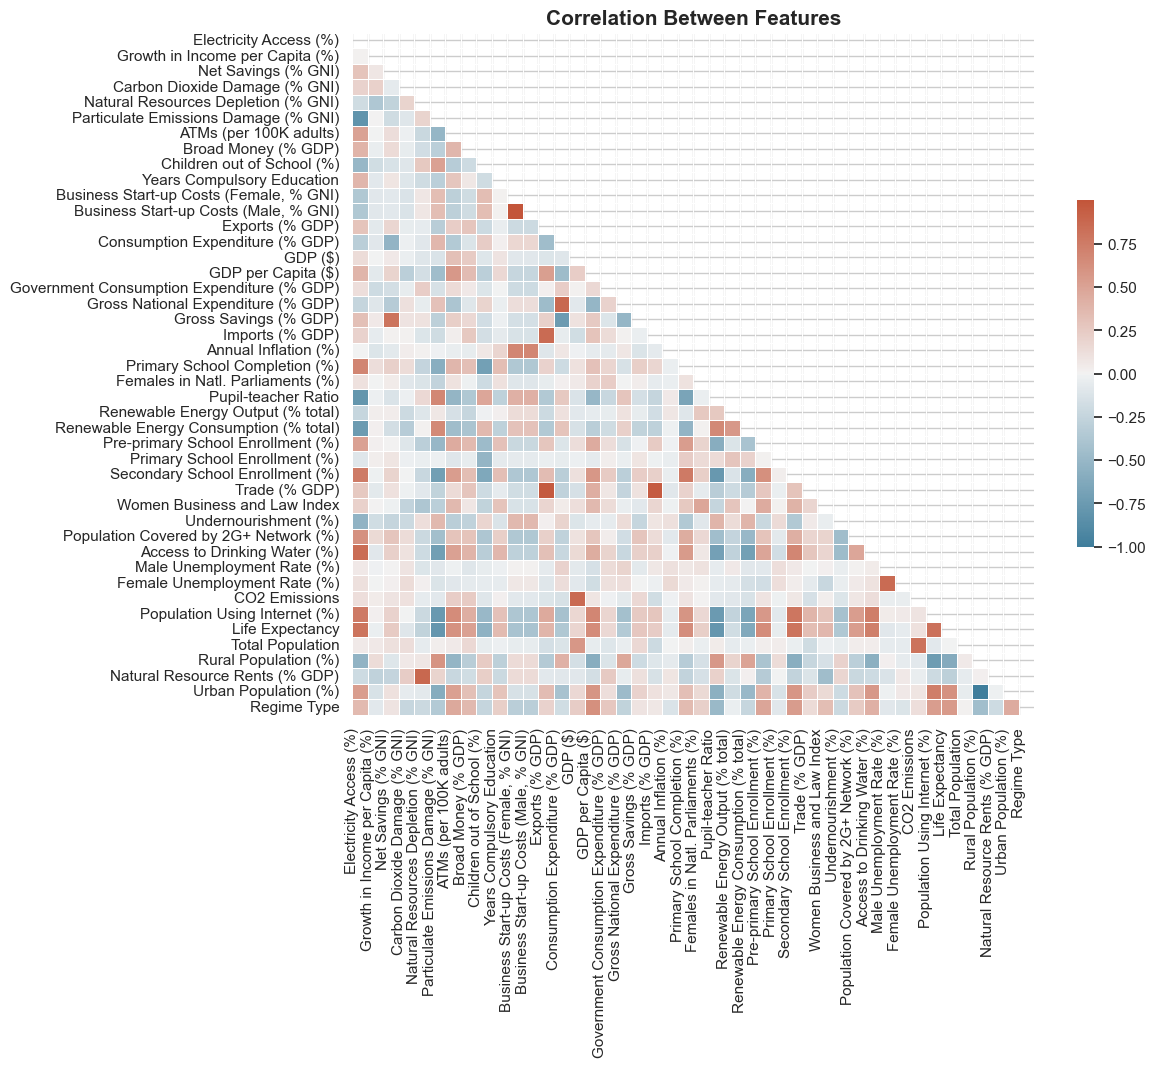

In [13]:
init_corr_viz = utils.viz_corr_heatmap(init_corr, False)
init_corr_viz.show()

/var/folders/j0/5yfrsf617z7b5_lkbnsqzmh80000gn/T/ipykernel_65491/3679950773.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  init_corr_abs_viz.show()


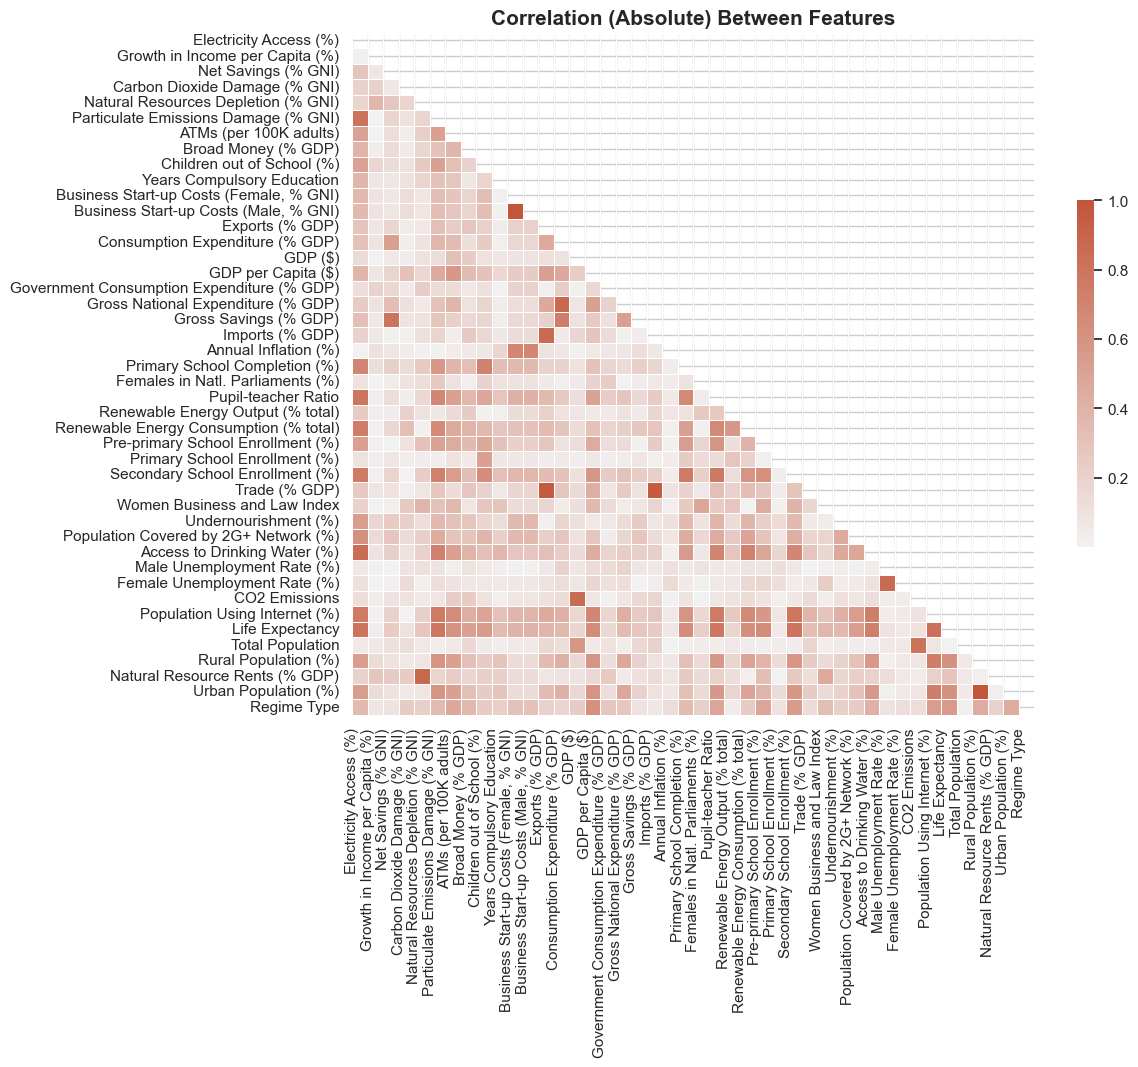

In [14]:
init_corr_abs_viz = utils.viz_corr_heatmap(init_corr.abs(), True)
init_corr_abs_viz.show()

Eliminate highly correlated features. We will output each feature, followed by any features that have a correlation of over 0.6 with the given feature. Using this information, we will decide if we'd like to retain both features or only keep one.

In [15]:
for series_name, series in init_corr.abs().items():
    high_corr = series[(series > 0.6) & (series != 1)]
    if not high_corr.empty:
        print(series_name + " ------")
        print(high_corr)
        print("")

Electricity Access (%) ------
Particulate Emissions Damage (% GNI)      0.806976
Primary School Completion (%)             0.693028
Pupil-teacher Ratio                       0.794421
Renewable Energy Consumption (% total)    0.743342
Secondary School Enrollment (%)           0.756570
Population Covered by 2G+ Network (%)     0.609961
Access to Drinking Water (%)              0.850980
Population Using Internet (%)             0.764076
Life Expectancy                           0.799997
Name: Electricity Access (%), dtype: float64

Net Savings (% GNI) ------
Gross Savings (% GDP)    0.801832
Name: Net Savings (% GNI), dtype: float64

Natural Resources Depletion (% GNI) ------
Natural Resource Rents (% GDP)    0.877162
Name: Natural Resources Depletion (% GNI), dtype: float64

Particulate Emissions Damage (% GNI) ------
Electricity Access (%)                    0.806976
Pupil-teacher Ratio                       0.672545
Renewable Energy Consumption (% total)    0.659849
Secondary School En

From these findings, we make the following decisions:
- Keep Natural Resources Rents, but drop Natural Resource Depletion; we do not believe there is much additional value in keeping both, and rents captures more information due to its economic implications.
- Drop Business Start-up Costs Male and keep Business Start-up Costs Female; these appear to be identical features.
- Drop Gross National Expenditure and keep Consumption Expenditure; both are very similar, but we prefer looking consumption specifically  due to its environmental concerns.
- Drop Coverage by 2G and 3G Networks but keep Internet Usage; we feel actual ability to use of internet easily (say, through a library or other public service) is more important than potentially expensive 2G or 3G services.
- Drop Urban Population but keep Rural Population; these features are very similar but Urban Population was more correlated with other features, so we choose to keep Rural Population.

Feature Engineering:
- Drop exports, imports, and trade (all highly correlated). Instead, make a trade deficit variable (exports - imports).
- Drop CO2 Emissions and create a CO2 Emissions per Capita measure. The current measure are raw emissions, so it is correlated with total population. We don't think CO2 Emissions alone is a useful feature, per Capita is much more informative.

In [16]:
df_uncorr = df.copy()

# Feature Engineering
df_uncorr["Trade Deficit (% GDP)"] = (
    df_uncorr["Exports (% GDP)"] - df_uncorr["Imports (% GDP)"]
)

# CO2 Emissions were Measured in Million Tonnes
df_uncorr["CO2 Emissions per Capita"] = (
    df_uncorr["CO2 Emissions"] * 1000000 / df_uncorr["Total Population"]
)

# Feature Selection
df_uncorr = df_uncorr.drop(
    columns=[
        "Exports (% GDP)",
        "Imports (% GDP)",
        "Trade (% GDP)",
        "CO2 Emissions",
        "Natural Resources Depletion (% GNI)",
        "Business Start-up Costs (Male, % GNI)",
        "Gross National Expenditure (% GDP)",
        "Urban Population (%)"
    ]
)

In [17]:
dropped_corr = df_uncorr.corr()

/var/folders/j0/5yfrsf617z7b5_lkbnsqzmh80000gn/T/ipykernel_65491/3842463103.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  init_dropped_corr_viz.show()


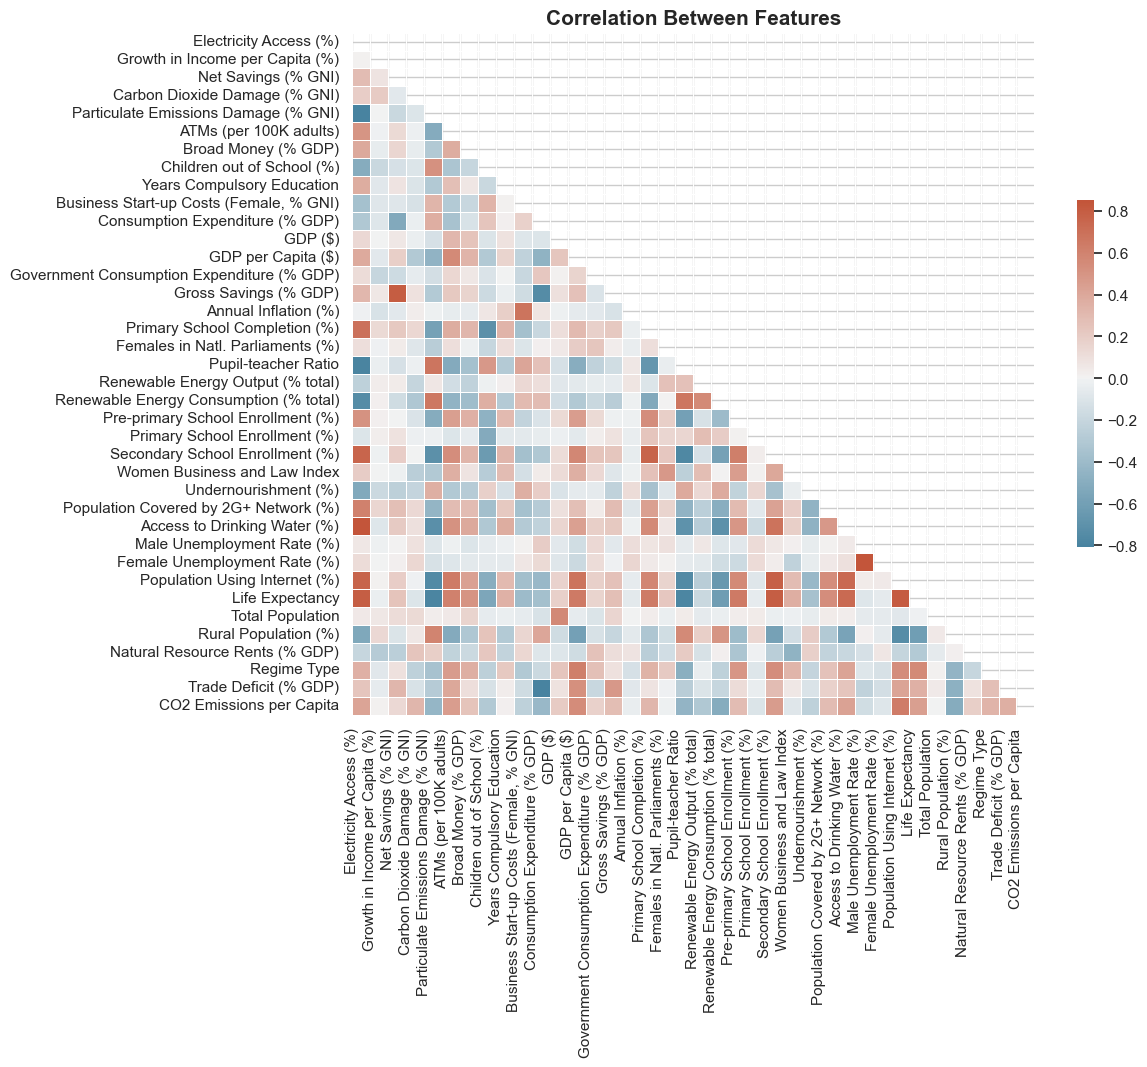

In [18]:
init_dropped_corr_viz = utils.viz_corr_heatmap(dropped_corr, False)
init_dropped_corr_viz.show()

/var/folders/j0/5yfrsf617z7b5_lkbnsqzmh80000gn/T/ipykernel_65491/596462957.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  init_dropped_corr_abs_viz.show()


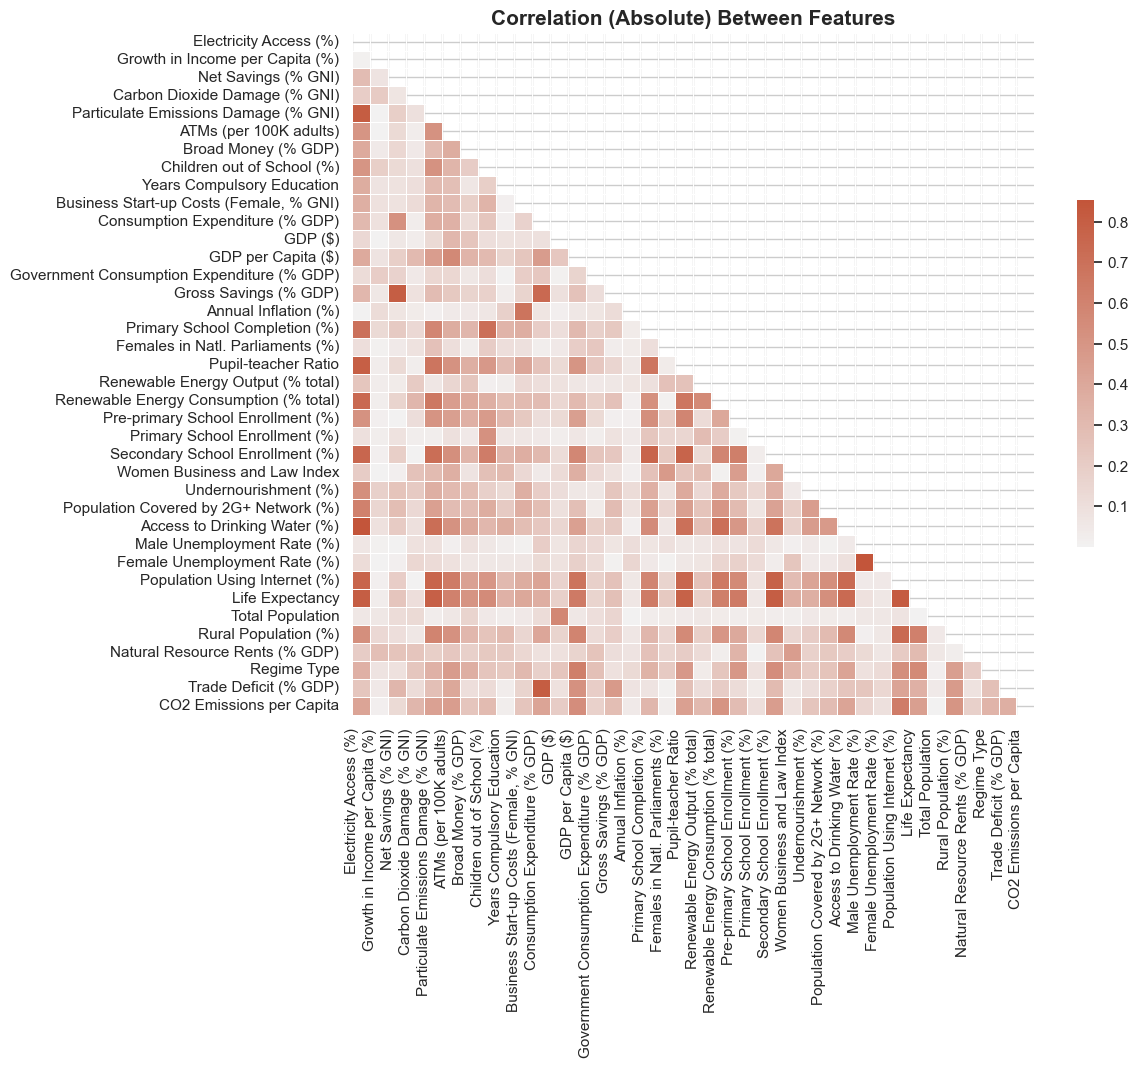

In [19]:
init_dropped_corr_abs_viz = utils.viz_corr_heatmap(dropped_corr.abs(), True)
init_dropped_corr_abs_viz.show()

### PCA after Feature Engineering

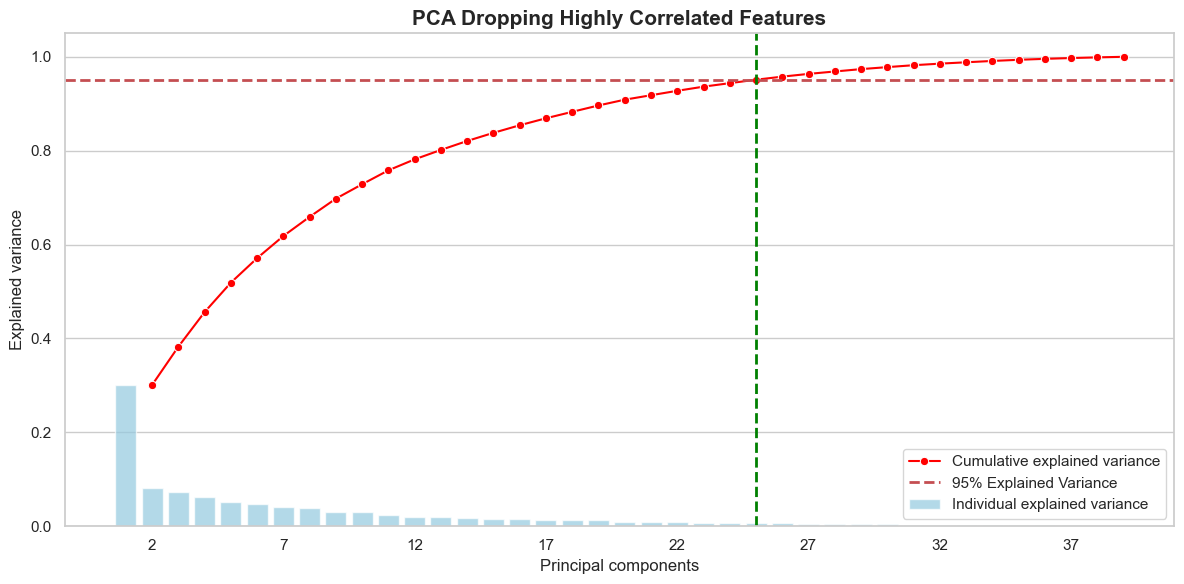

In [20]:
final_pca, final_pca_df = utils.create_pca(df_uncorr)
final_pca_viz = utils.viz_pca(final_pca, "Dropping Highly Correlated Features")
final_pca_viz.show()

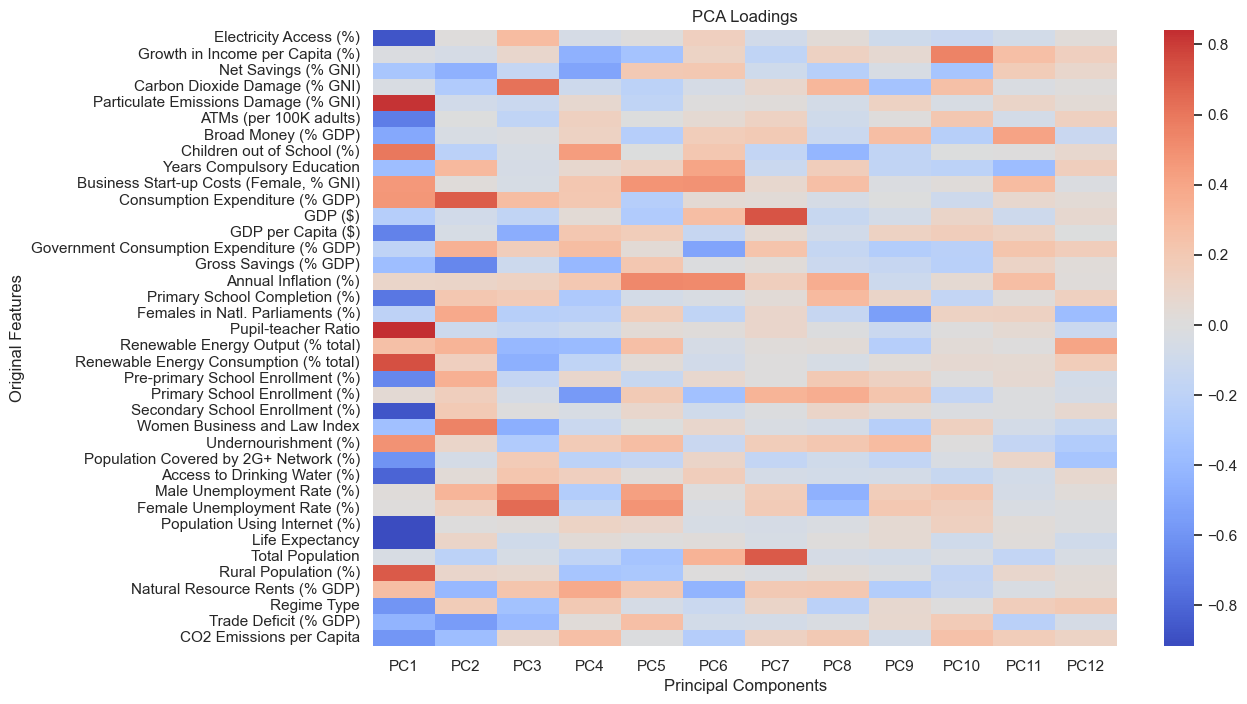

In [21]:
num_components = 12
final_pca_n, final_pca_heatmap = utils.viz_pca_heatmap(df_uncorr, 12)
final_pca_heatmap.show()

In [22]:
final_loadings = utils.create_loadings(df_uncorr, final_pca_n)
utils.print_top_features_for_component(final_pca_n, final_loadings, 5)

PC1 top 5 features and explained variance:
Life Expectancy: 0.8397
Population Using Internet (%): 0.8397
Electricity Access (%): 0.7635
Secondary School Enrollment (%): 0.7616
Pupil-teacher Ratio: 0.7067

PC2 top 5 features and explained variance:
Consumption Expenditure (% GDP): 0.4801
Gross Savings (% GDP): 0.4304
Trade Deficit (% GDP): 0.3146
Women Business and Law Index: 0.3123
Net Savings (% GNI): 0.1993

PC3 top 5 features and explained variance:
Female Unemployment Rate (%): 0.4161
Carbon Dioxide Damage (% GNI): 0.3788
Male Unemployment Rate (%): 0.2794
GDP per Capita ($): 0.2163
Women Business and Law Index: 0.2104

PC4 top 5 features and explained variance:
Primary School Enrollment (%): 0.3247
Net Savings (% GNI): 0.2658
Growth in Income per Capita (%): 0.1963
Children out of School (%): 0.1919
Gross Savings (% GDP): 0.1662

PC5 top 5 features and explained variance:
Annual Inflation (%): 0.2809
Business Start-up Costs (Female, % GNI): 0.2332
Female Unemployment Rate (%): 0.2

From this analysis, we can label the top components based on which original features explain their variance:

PC1: Human Development \
PC2: Trade \
PC3: Business Practices \
PC4: Personal Wealth \
PC5: Personal Economic / Business Environment \
PC6: National Economic / Business Environment \
PC7: Capital and Human Resources 

After PC7 it is hard to label with any dominant theme.

### GMM
Chosen because it is good for high dimensional data 

In [23]:
def gmm_bic_score(estimator, X):
    return -estimator.bic(X)

param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(final_pca_df)

c:\Users\nicho\anaconda3\envs\ml_hw2\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\nicho\anaconda3\envs\ml_hw2\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\nicho\anaconda3\envs\ml_hw2\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\nicho\anaconda3\envs\ml_hw2\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 7)},
             scoring=<function gmm_bic_score at 0x0000020DE3957F40>)

In [24]:
grid_res = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
grid_res["mean_test_score"] = -grid_res["mean_test_score"]
grid_res = grid_res.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
grid_res.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
12,1,diag,2957.786546
13,2,diag,3097.684849
14,3,diag,3390.358615
15,4,diag,3660.075406
1,2,spherical,3725.213769


c:\Users\nicho\anaconda3\envs\ml_hw2\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


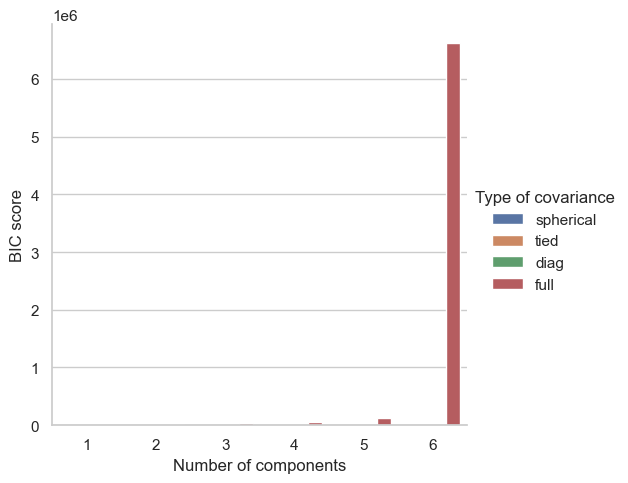

In [25]:
sns.catplot(
    data=grid_res,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

Drop "full" to better visualize

c:\Users\nicho\anaconda3\envs\ml_hw2\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


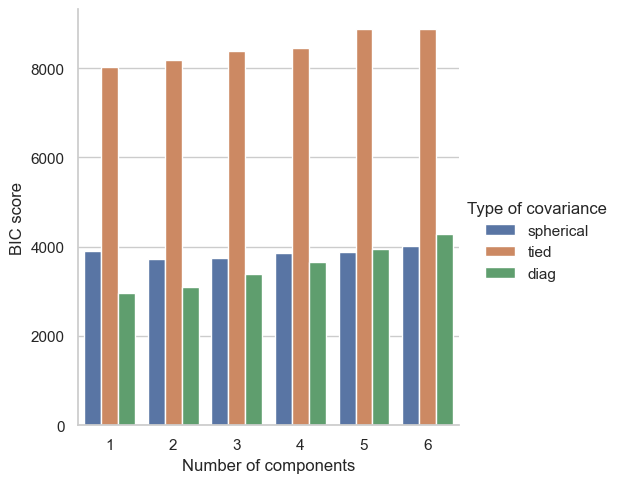

In [26]:
sns.catplot(
    data=grid_res[grid_res["Type of covariance"] != "full"],
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

PCA with 2 components is chosen for visualization purposes. Could also do 3 and make a 3d plot.

In [27]:
gmm = GaussianMixture(n_components=2, covariance_type="diag")
gmm_res = gmm.fit_predict(final_pca_df)
final_pca_df["cluster"] = gmm_res

c:\Users\nicho\anaconda3\envs\ml_hw2\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


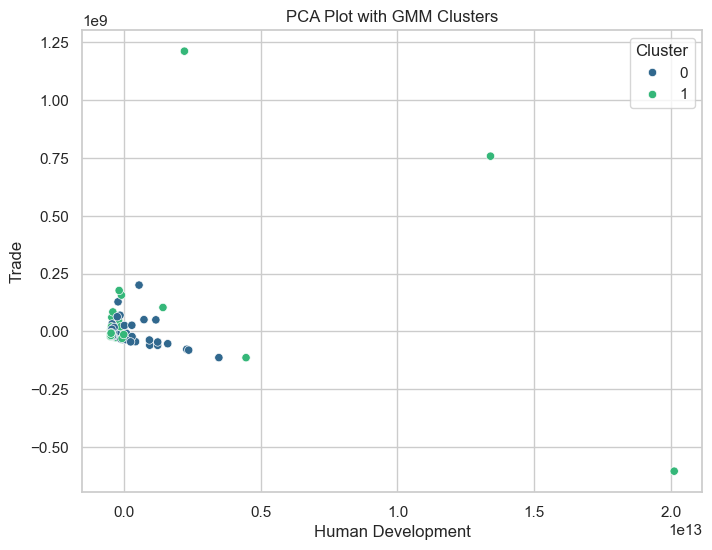

In [28]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_uncorr)

pca_df = pd.DataFrame(data=pca_result, columns=["PCA1", "PCA2"])
pca_df["cluster"] = gmm_res

plt.figure(figsize=(8, 6))
scatterplot = sns.scatterplot(
    x="PCA1", y="PCA2", hue="cluster", data=pca_df, palette="viridis"
)

scatterplot.set_title("PCA Plot with GMM Clusters")
plt.legend(title="Cluster")
plt.xlabel("Human Development")
plt.ylabel("Trade")

plt.show()

Drop outliers again

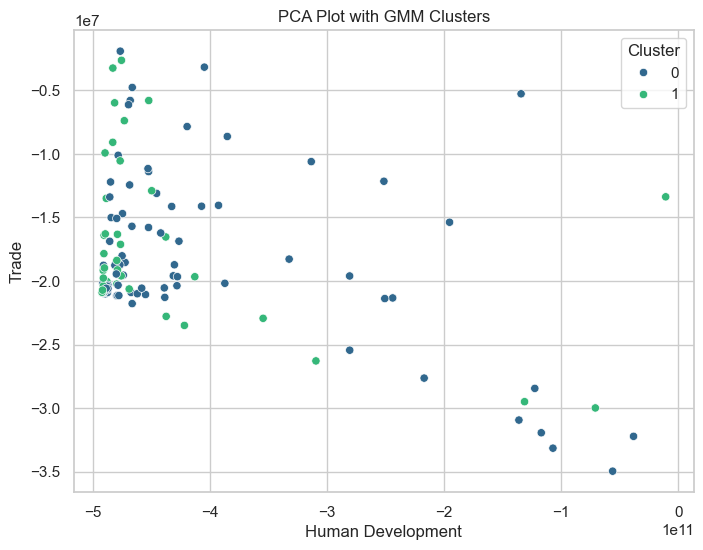

In [29]:
pca_df = pca_df[~(pca_df["PCA1"] > 0.5) & ~(pca_df["PCA2"] > 0.25)]

plt.figure(figsize=(8, 6))
scatterplot = sns.scatterplot(
    x="PCA1", y="PCA2", hue="cluster", data=pca_df, palette="viridis"
)

plt.xlabel("Human Development")
plt.ylabel("Trade")

scatterplot.set_title("PCA Plot with GMM Clusters")
plt.legend(title="Cluster")